In [125]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import time
from zipline.api import (
    order,
    record,
    symbol,
    set_benchmark,
)
import pyfolio as pf
import pandas_datareader.data as web
from zipline import run_algorithm
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import warnings
warnings.filterwarnings("ignore")
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap


############
# stock data loader and GRU model
# import StockDate and GRUModel
project_base = Path.cwd().resolve().parent.parent
sys.path.append(str(project_base))
from util import StockData, GRUModel

In [126]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [127]:
ticker = 'NVDA'
start='2001-01-01'
end='2024-12-30'
security = StockData(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [128]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

gru_model = GRUModel(input_dim, hidden_dim, num_layers, output_dim)
saved_model = Path().cwd().parent / "GRU/gru_stock_pred.pth"
if not saved_model.exists():
    Path.mkdir(Path().cwd().parent / "GRU", exist_ok=True)

if saved_model.parent.exists():
    gru_model.load_state_dict(torch.load(saved_model))
else:
    X_train, y_train, X_test, y_test = security.train_valid_split()
    train_df, test_df = security.get_train_test_data_frame()
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(gru_model.parameters(), lr=0.01)
    # train
    num_epochs = 200
    hist = np.zeros(num_epochs)
    start_time = time.time()
    gru = []
    for t in range(num_epochs):
        y_train_pred = gru_model(X_train)

        loss = criterion(y_train_pred, y_train)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    torch.save(gru_model.state_dict(), saved_model)

In [144]:
# backtesting with zipline
# Initialize the strategy
def initialize(context):
    context.asset = symbol(ticker)  # Replace with your stock ticker
    set_benchmark(context.asset)
    context.lookback = 20  # Lookback window for prediction
    context.predictions = []


# Define the handle_data function
def handle_data(context, data):
    # Example: Use the GRU model to predict next day's price

    lookback_prices = data.history(context.asset, "close", context.lookback, "1d")
    scaled_prices = (lookback_prices - lookback_prices.min()) / (lookback_prices.max() - lookback_prices.min())
    prediction = predict_next_day(scaled_prices)  # Your GRU prediction function

    # Decision: Buy or Sell
    current_price = data.current(context.asset, "price")
    if prediction > current_price:
        order(context.asset, 10)  # Buy
        decision = 'buy'
    elif prediction < current_price:
        order(context.asset, -10)  # Sell
        decision = 'sell'
    print(f"Handling data for {data.current_dt.date()}, current price: {current_price}, prediction: {prediction}, decision: {decision}")

    # Record data for analysis
    # how can you use this?
    record(prediction=prediction, price=current_price, decision=decision)


# Example: Dummy function for prediction
def predict_next_day(scaled_prices):

    scaled_prices = np.asarray(scaled_prices)
    scaled_prices = scaled_prices[np.newaxis, :, np.newaxis]
    scaled_prices_tensor = torch.from_numpy(scaled_prices).to(torch.float32)
    pred = gru_model(scaled_prices_tensor)
    pred =  security.scaler.inverse_transform(pred.detach().numpy().reshape(-1,1))
    return pred.reshape(-1)[0]

def analyze(perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax2 = plt.subplot(212, sharex=ax1)
    perf.price.plot(ax=ax2)
    plt.gcf().set_size_inches(18, 8)
    plt.show()

Handling data for 2015-01-02, current price: 20.13, prediction: 103.73870849609375, decision: buy
Handling data for 2015-01-05, current price: 19.79, prediction: 98.09772491455078, decision: buy
Handling data for 2015-01-06, current price: 19.19, prediction: 92.44195556640625, decision: buy
Handling data for 2015-01-07, current price: 19.135, prediction: 84.44696807861328, decision: buy
Handling data for 2015-01-08, current price: 19.86, prediction: 91.72637939453125, decision: buy
Handling data for 2015-01-09, current price: 19.94, prediction: 97.77576446533203, decision: buy
Handling data for 2015-01-12, current price: 19.69, prediction: 96.79644775390625, decision: buy
Handling data for 2015-01-13, current price: 19.655, prediction: 95.05354309082031, decision: buy
Handling data for 2015-01-14, current price: 19.740000000000002, prediction: 95.42301940917969, decision: buy
Handling data for 2015-01-15, current price: 19.6, prediction: 93.75841522216797, decision: buy
Handling data f

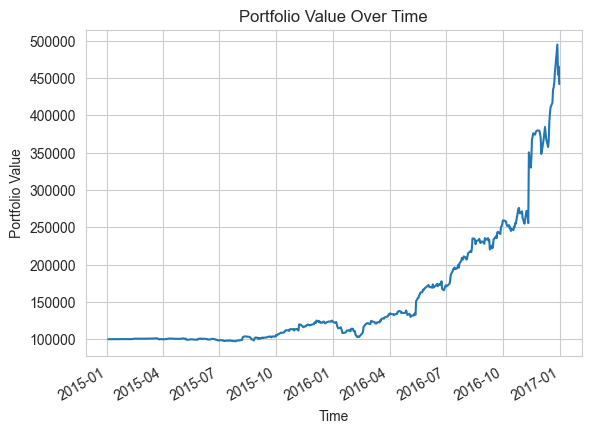

In [148]:
# Run the backtest
if __name__ == "__main__":
    # I picked two random time. Obviously, there are a lot of parameters you can tune
    start = pd.Timestamp("2015-01-01", tz=None)
    end = pd.Timestamp("2016-12-31", tz=None)
    result = run_algorithm(start=start,
                           end=end,
                           initialize=initialize,
                           handle_data=handle_data,
                           capital_base=100000,
                           bundle="quandl")

    result.portfolio_value.plot(title="Portfolio Value Over Time")
    plt.xlabel("Time")  # Optional: Add a label to the x-axis
    plt.ylabel("Portfolio Value")  # Optional: Add a label to the y-axis
    plt.savefig("portfolio_value.png")
    plt.show()

In [149]:
result

,period_open,period_close,returns,pnl,capital_used,orders,transactions,positions,starting_exposure,ending_exposure,...,treasury_period_return,trading_days,algorithm_period_return,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta,sharpe
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.000000,0.000000,0.000000,"[{'id': '1237a3fb43a147f791a6613a09b91b49', 'd...",[],[],0.00,0.00,...,0.0,1,0.000000,2015-01,NaN,0.003993,NaN,NaN,NaN,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,-0.000001,-0.108950,-198.008950,"[{'id': '1237a3fb43a147f791a6613a09b91b49', 'd...","[{'amount': 10, 'dt': 2015-01-05 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 10, 'c...",0.00,197.90,...,0.0,2,-0.000001,2015-01,0.000012,-0.012950,0.234246,-0.000053,0.000052,-11.224972
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,-0.000061,-6.105950,-192.005950,"[{'id': 'ade8d145d1bb4472ba752b469828393f', 'd...","[{'amount': 10, 'dt': 2015-01-06 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 20, 'c...",197.90,383.80,...,0.0,3,-0.000062,2015-01,0.000555,-0.042895,0.274593,0.000697,0.001630,-9.411520
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,-0.000012,-1.205675,-191.455675,"[{'id': 'da326db5f89f428aa6d54d05688370b2', 'd...","[{'amount': 10, 'dt': 2015-01-07 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 30, 'c...",383.80,574.05,...,0.0,4,-0.000074,2015-01,0.000458,-0.045608,0.242290,-0.000313,0.001503,-10.205417
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,0.000216,21.640700,-198.709300,"[{'id': 'f8cead126b6846ff9482f8dd3b37d8c3', 'd...","[{'amount': 10, 'dt': 2015-01-08 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 40, 'c...",574.05,794.40,...,0.0,5,0.000142,2015-01,0.001715,-0.009470,0.408557,0.008816,0.003900,4.180204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23 21:00:00+00:00,2016-12-23 14:31:00+00:00,2016-12-23 21:00:00+00:00,0.029959,13296.041100,-1098.358900,"[{'id': '79a34fce9f2d4a0d941eec794c7c318f', 'd...","[{'amount': 10, 'dt': 2016-12-23 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 4990, ...",533407.80,547802.20,...,0.0,500,3.571036,2016-12,0.368211,4.619369,0.406929,0.067349,0.803016,2.247416
2016-12-27 21:00:00+00:00,2016-12-27 14:31:00+00:00,2016-12-27 21:00:00+00:00,0.082310,37624.003400,-1173.796600,"[{'id': 'd286122f5581468682866f5f1eb5d071', 'd...","[{'amount': 10, 'dt': 2016-12-27 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 5000, ...",547802.20,586600.00,...,0.0,501,3.947276,2016-12,0.372088,5.005324,0.409121,0.076325,0.808263,2.330828
2016-12-28 21:00:00+00:00,2016-12-28 14:31:00+00:00,2016-12-28 21:00:00+00:00,-0.081561,-40350.556250,-1093.056250,"[{'id': 'afc5d75c22cb499f8b6df2a1474d833f', 'd...","[{'amount': 10, 'dt': 2016-12-28 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 5010, ...",586600.00,547342.50,...,0.0,502,3.543771,2016-12,0.376564,4.592240,0.411944,0.056582,0.813908,2.189808
2016-12-29 21:00:00+00:00,2016-12-29 14:31:00+00:00,2016-12-29 21:00:00+00:00,0.024036,10921.232850,-1114.867150,"[{'id': 'c66f7a5205b24bea9ba5a6b8dcf67501', 'd...","[{'amount': 10, 'dt': 2016-12-29 21:00:00+00:0...","[{'sid': Equity(2046 [NVDA]), 'amount': 5020, ...",547342.50,559378.60,...,0.0,503,3.652983,2016-12,0.376475,4.703829,0.411693,0.060232,0.814271,2.217952


In [150]:
(result.price[-1] - result.price[0])/result.price[0]

4.302533532041729

In [151]:
(result.portfolio_value[-1] - result.portfolio_value[0])/result.portfolio_value[0]

3.4175394715000085

In [152]:
transactions = result.loc[:, ['price', 'prediction', 'decision']]
transactions

,price,prediction,decision
2015-01-02 21:00:00+00:00,20.130,103.738708,buy
2015-01-05 21:00:00+00:00,19.790,98.097725,buy
2015-01-06 21:00:00+00:00,19.190,92.441956,buy
2015-01-07 21:00:00+00:00,19.135,84.446968,buy
2015-01-08 21:00:00+00:00,19.860,91.726379,buy
...,...,...,...
2016-12-23 21:00:00+00:00,109.780,120.918640,buy
2016-12-27 21:00:00+00:00,117.320,117.652596,buy
2016-12-28 21:00:00+00:00,109.250,117.079735,buy
2016-12-29 21:00:00+00:00,111.430,117.209145,buy


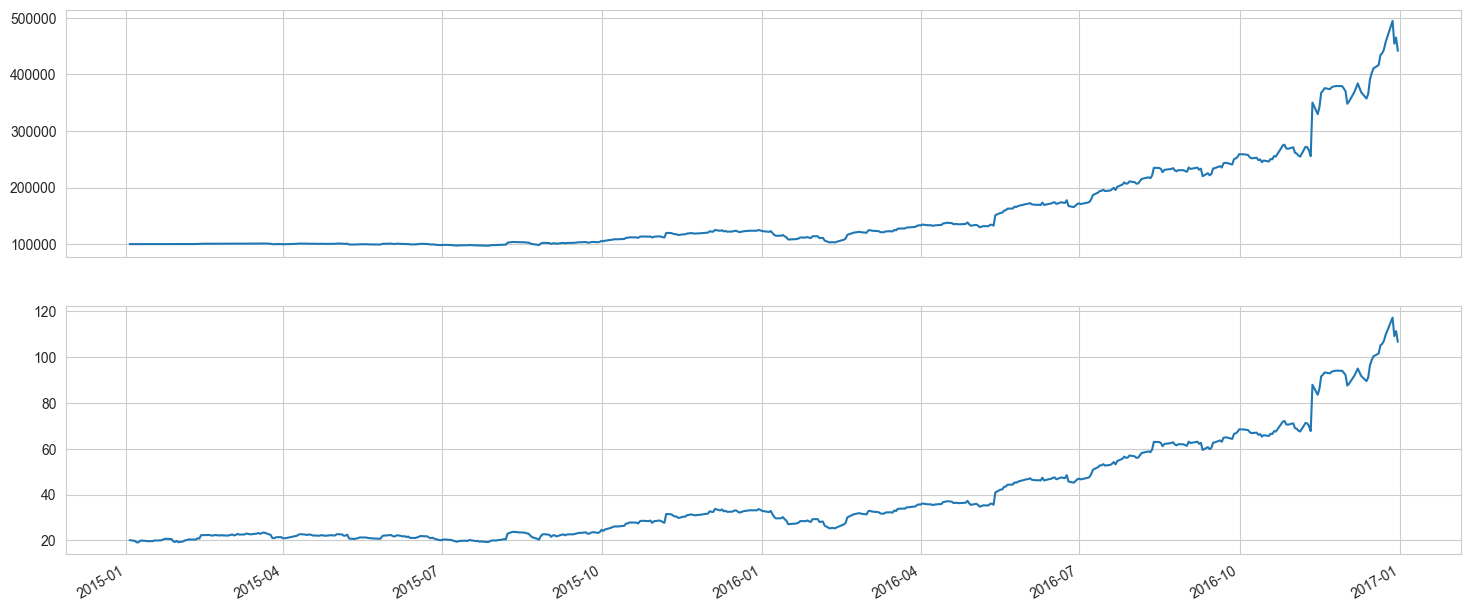

In [153]:
analyze(perf=result)

In [154]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)

In [155]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2017').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [159]:
LIVE_DATE = '2016-01-01'

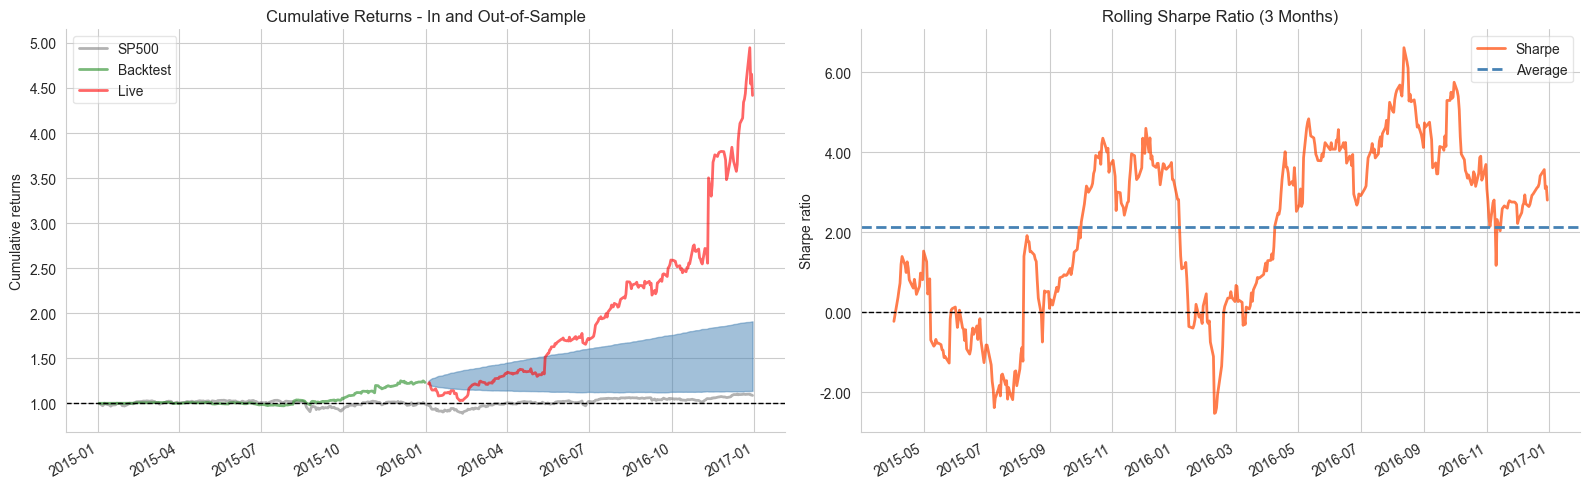

In [160]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout();

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.75,2015-12-04,2016-02-08,2016-03-16,74
1,10.71,2016-12-27,2016-12-30,NaT,NaN
2,8.27,2016-11-25,2016-12-01,2016-12-07,9
3,7.67,2016-10-26,2016-11-04,2016-11-11,13
4,6.96,2016-12-07,2016-12-12,2016-12-14,6


Stress Events,mean,min,max
Fall2015,0.07%,-1.50%,2.52%
New Normal,0.32%,-8.16%,37.08%


Top 10 long positions of all time,max
sid,
NVDA,124.39%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
NVDA,124.39%


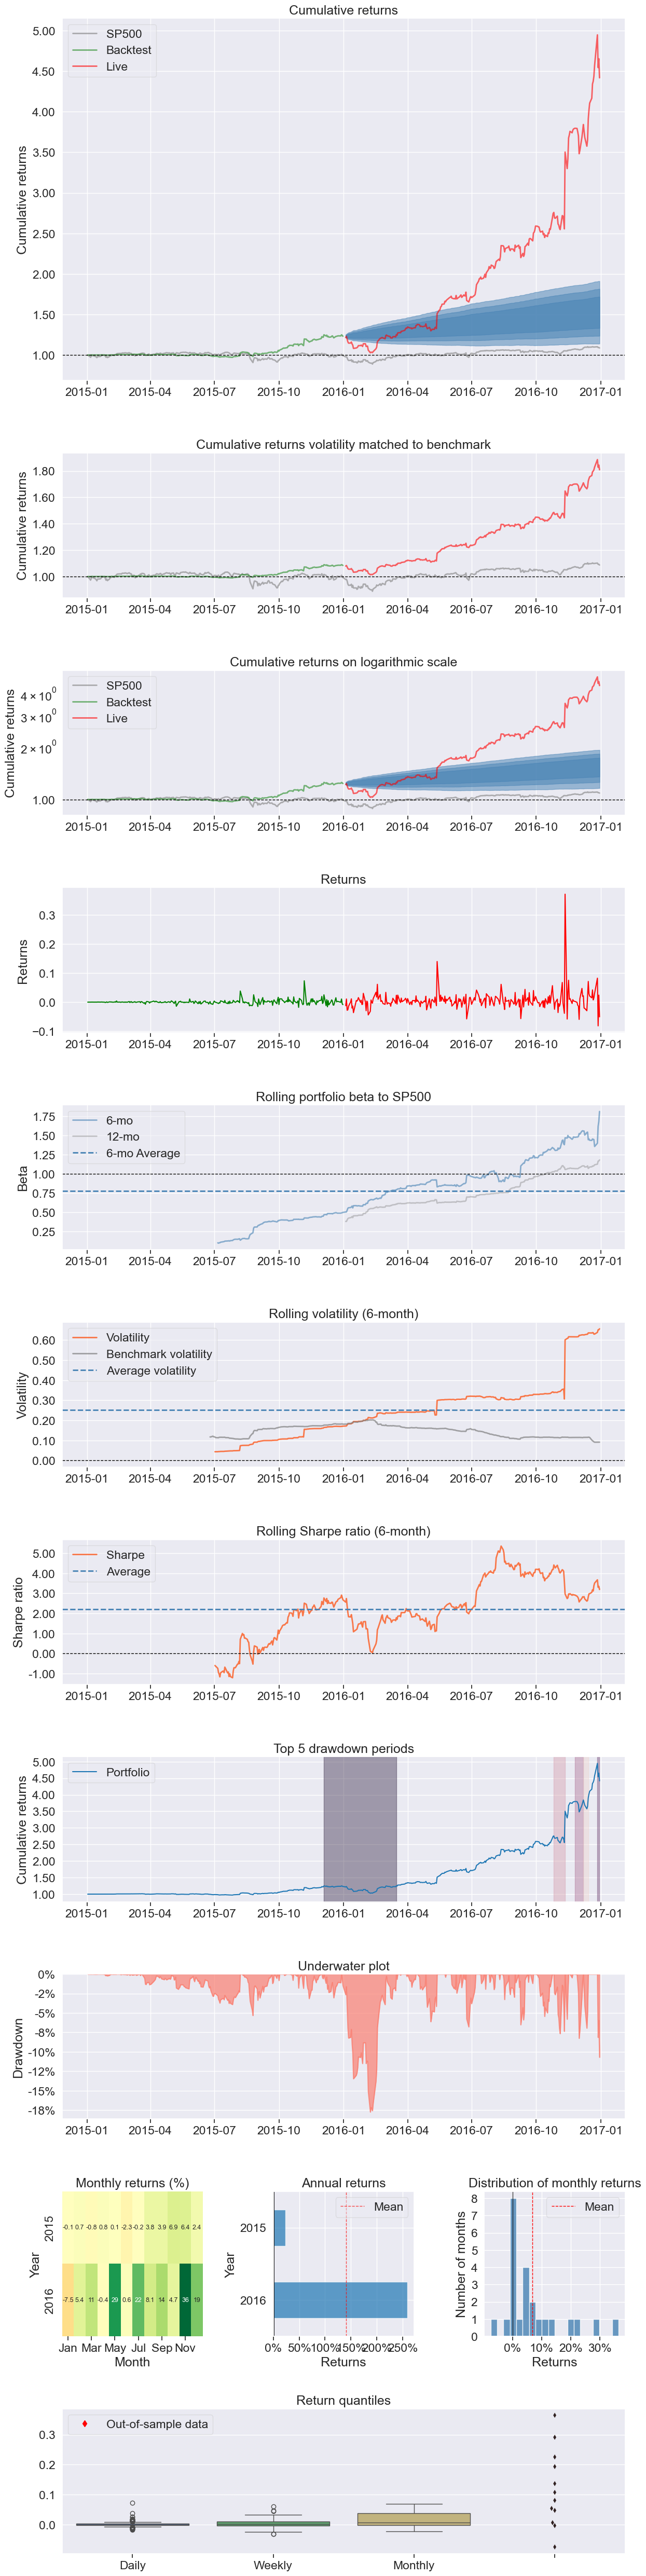

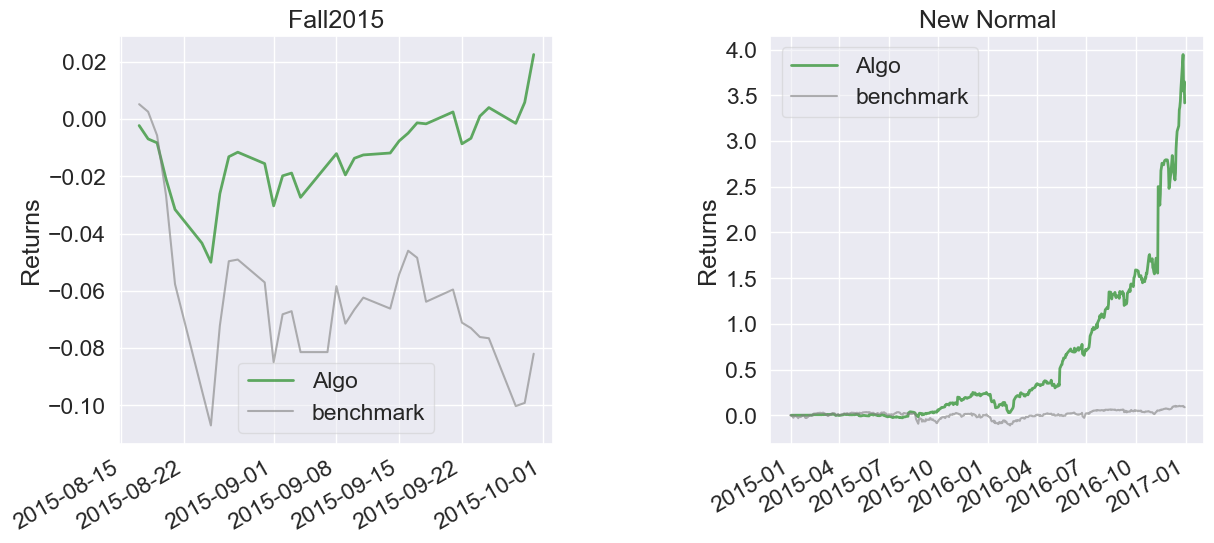

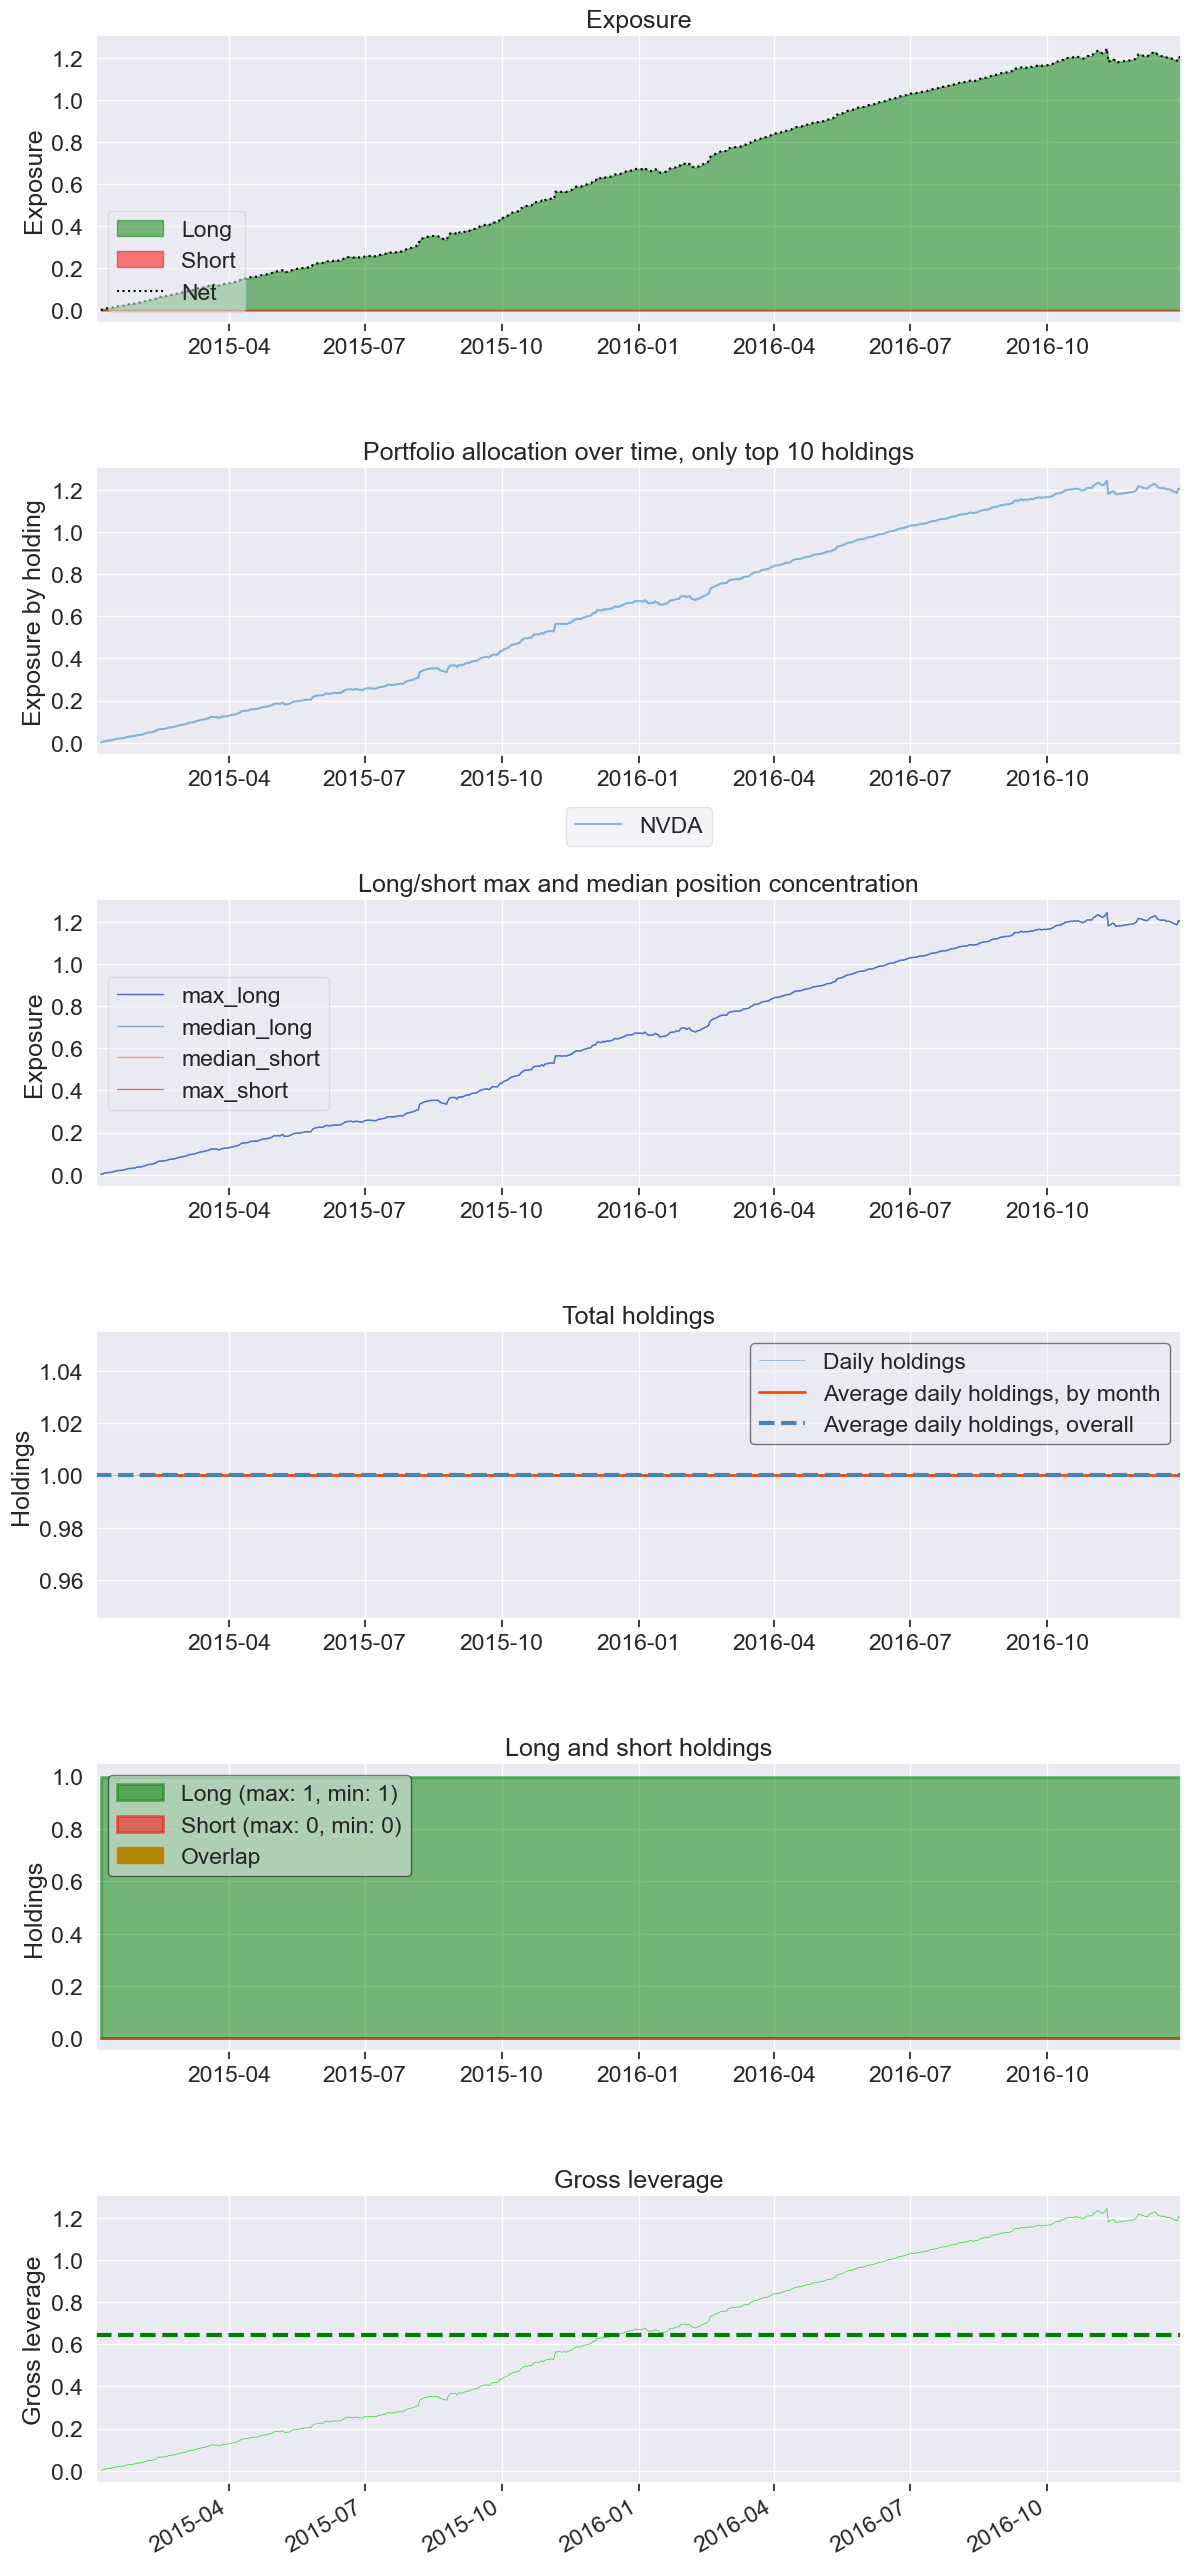

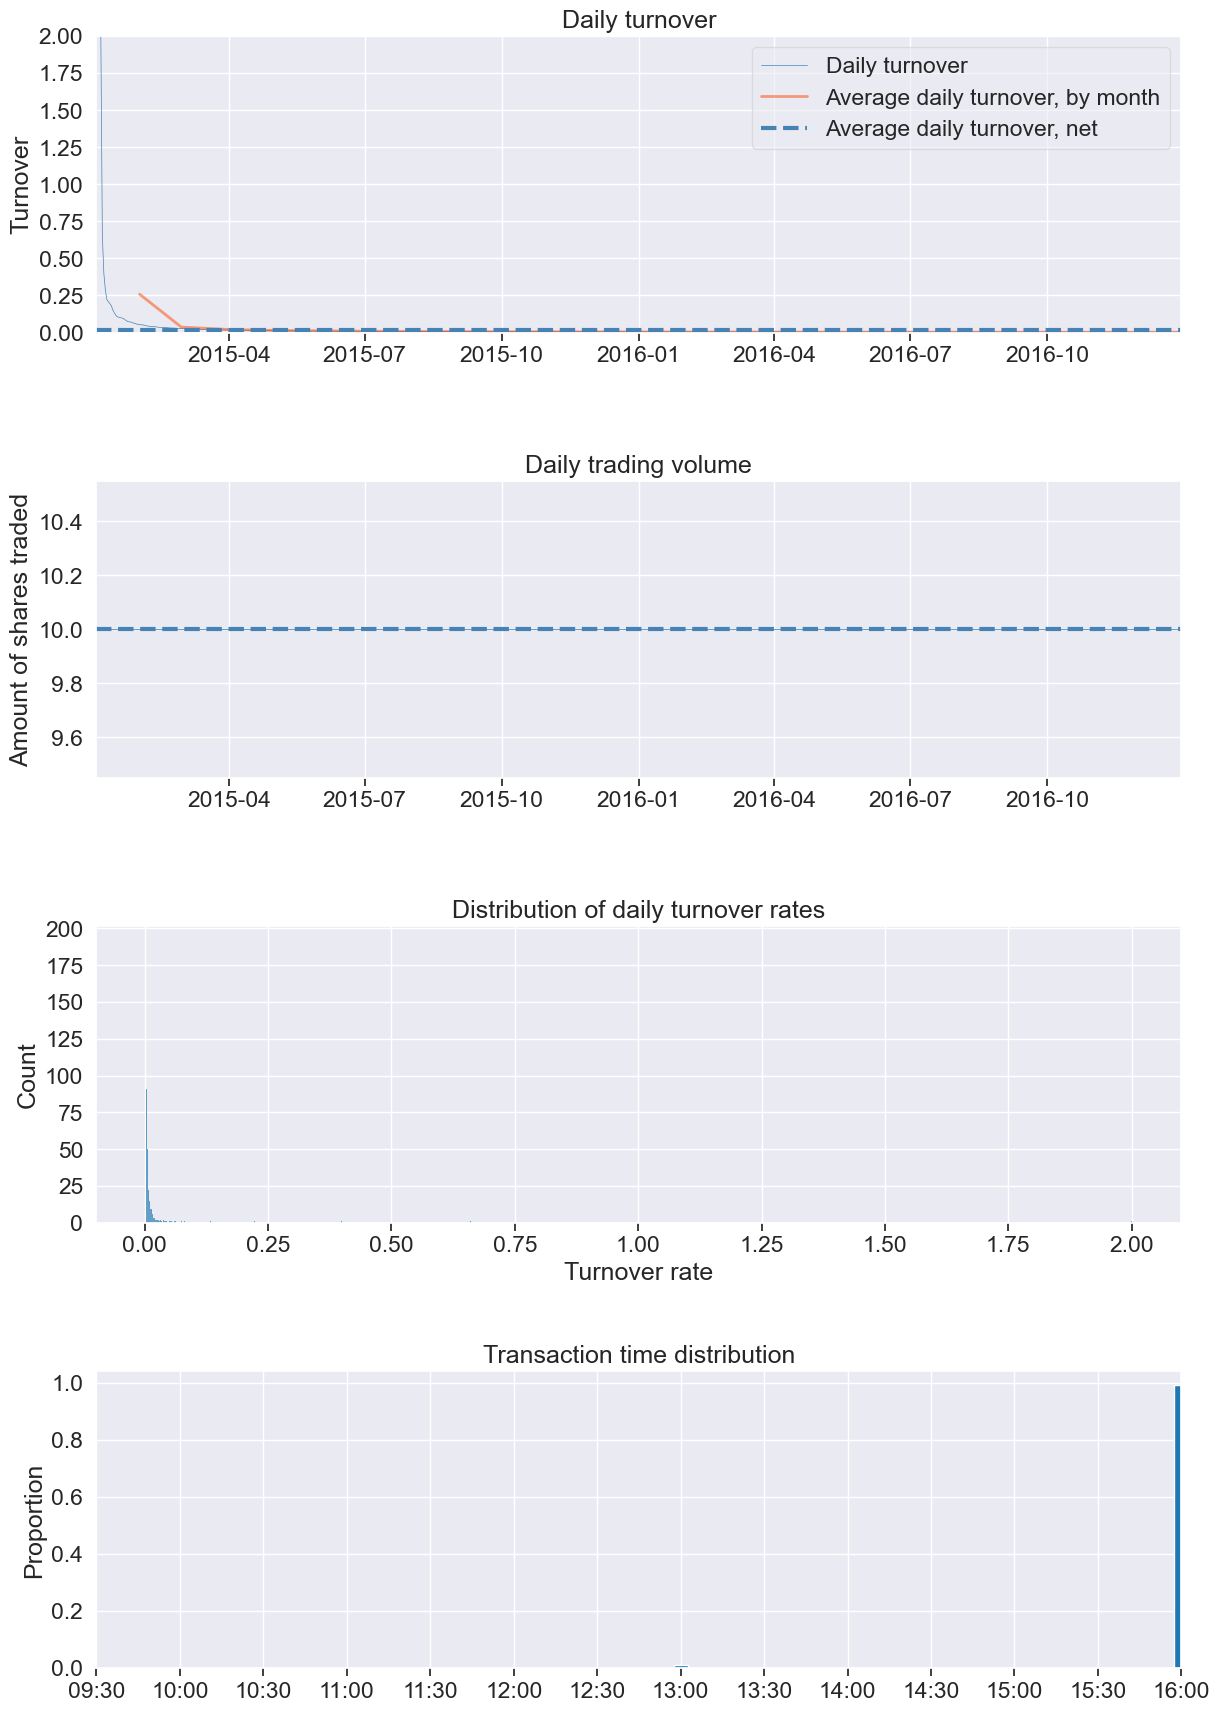

In [161]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date=LIVE_DATE,
                          round_trips=True)